**CATEGORIES** :
- COMPTE, FRAIS D'ANNULATION , LIVRAISON, COMMENTAIRES, FACTURE, NEWSLETTER, COMMANDE, PAIEMENT, REMBOURSEMENT, ADRESSE_DE_LIVRAISON,

**INTENTIONS** : 27

**FLAGS** : \
Structure syntaxique :
- B : structure syntaxique de base
- I : Structure interrogative
- C : Structure syntaxique coordonnée « J'ai une nouvelle carte SIM, que dois-je faire pour l'activer ? »
- N : Négation\

[...]

### **IMPORTS**

In [37]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.8 MB/s eta 0:00:00


In [1]:
# Preprocessing
import re
import string
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import resample

# Token
import json
from transformers import GPT2Tokenizer
import tiktoken

# Normalisation
import openai
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [93]:
# Import data from Hugging face
df = pd.read_csv("hf://datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

In [75]:
df.shape

(26872, 5)

In [6]:
pandas_df = pd.DataFrame(df)

# pandas_df.query("flags == 'B'")

pandas_df

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
...,...,...,...,...,...
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance..."
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...


No charts were generated by quickchart


### **EXPLORATION**

In [12]:
# To see responses by category
response_by_cat = pandas_df.groupby('category')['response'].count()
print(f"By category : {response_by_cat}\n")

# To see responses by intent
response_by_intent = pandas_df.groupby('intent')['response'].count()
print(f"By intent : {response_by_intent}")

By category : category
ACCOUNT         5986
CANCEL           950
CONTACT         1999
DELIVERY        1994
FEEDBACK        1997
INVOICE         1999
ORDER           3988
PAYMENT         1998
REFUND          2992
SHIPPING        1970
SUBSCRIPTION     999
Name: response, dtype: int64

By intent : intent
cancel_order                 998
change_order                 997
change_shipping_address      973
check_cancellation_fee       950
check_invoice               1000
check_payment_methods        999
check_refund_policy          997
complaint                   1000
contact_customer_service    1000
contact_human_agent          999
create_account               997
delete_account               995
delivery_options             995
delivery_period              999
edit_account                1000
get_invoice                  999
get_refund                   997
newsletter_subscription      999
payment_issue                999
place_order                  998
recover_password             995
regi

**CATEGORY** :
> Les catégories présentant les plus d'examples : ``ACCOUNT`` (5986), ``ORDER`` (3988), ``REFUND``(2992).\
> Les autres sont aux alentours de 2000.\
> Et ``CANCEL`` (950), ``SUBSCRIPTION`` (999)

**INTENT** :
> Les ``27`` intentions assignées aux catégories sont assez équilibrées (autour de 1000 chacune)

In [ ]:
# Ecq il faut balancer les données / équilibrer les responses selon la catégorie quand mm ?

In [92]:
# # Example : rééchantillonage
# # Sous-échantillonner une catégorie dominante
# majority = df[df['category'] == 'ACCOUNT']    # et ORDER !!
# minority = df[df['category'] == 'CANCEL']     # et SUBSCRIPTION !!

# majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
# df_balanced = pd.concat([majority_downsampled, minority])

# **I. PREPROCESSING**

In [5]:
print(f"Types de données : {pandas_df.dtypes}\n")
print(f"Valeurs manquantes : {pandas_df.isna().sum()}\n")      # = 0
print(f"Valeurs dupliquées : {pandas_df.duplicated().sum()}")  # = 0

Types de données : flags          object
instruction    object
category       object
intent         object
response       object
dtype: object

Valeurs manquantes : flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64

Valeurs dupliquées : 0


### **1. CLEAN DATA**

In [27]:
df

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
...,...,...,...,...,...
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance..."
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...


In [68]:
df.columns

Index(['flags', 'instruction', 'category', 'intent', 'response'], dtype='object')

In [119]:
# Delete missing & duplicated values
data = df.copy()

data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [120]:
def clean_text(text):
    """
    """
    # On uniformise le texte
    text = text.lower()

    # On remplace {{Placeholder}} par <Placeholder> (dans instruction et response)
    text = re.sub(r'{{\s*(.*?)\s*}}', r'<\1>', text)

    return text

In [121]:
data['instruction'] = data['instruction'].apply(clean_text)
data['response'] = data['response'].apply(clean_text)

### **2. TOKENIZATION**

> - **tiktoken** utilise des encodages spécifiques pour différents modèles.
> - Pour les modèles de la famille GPT-3.5 et GPT-4, l'encodage recommandé est ``**cl100k_base**``, qui est optimisé pour ces modèles.

In [96]:
# Lister les encodages disponibles
print(tiktoken.list_encoding_names())

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base', 'o200k_base']


In [97]:
# Charger le tokenizer GPT-3.5 depuis tiktoken (BPE tokenizer)
# tokenizer = tiktoken.get_encoding("cl100k_base" if model_name == "gpt-3.5-turbo" else "p50k_base")    # ref github (https://github.com/openai/openai-python/issues/304)

tokenizer = tiktoken.get_encoding("cl100k_base")  # gpt 3.5 turbo utilise l'encoding cl100k_base

In [98]:
# Fonction pour compter les tokens
def count_tokens(text):
    return len(tokenizer.encode(text))

In [ ]:
data_cleaned = data.copy()
data_cleaned['instruction_tokens'] = data_cleaned['instruction'].apply(count_tokens)
data_cleaned['response_tokens'] = data_cleaned['response'].apply(count_tokens)

In [100]:
# Vérifier la longueur totale (instruction + réponse)
data_cleaned['total_tokens'] = data_cleaned['instruction_tokens'] + data_cleaned['response_tokens']

In [101]:
data_cleaned.query("total_tokens > 4096")

,flags,instruction,category,intent,response,instruction_tokens,response_tokens,total_tokens


In [ ]:
# Filtrer les exemples trop longs (limite GPT-3.5 : ~4096 tokens)
# On doit avoir au max 4k de tokens (instruction+response) pour chaque ligne

# data_cleaned = data_cleaned[data_cleaned['total_tokens'] <= 4096]     # nous n'avons pas ce cas dans le train

### **3. TRONQUER LES TEXTES**

In [ ]:
# Si on veut tronquer les textes d'abord

In [ ]:
# def truncate_text(text, max_tokens):
#     tokens = tokenizer.encode(text)
#     if len(tokens) > max_tokens:
#         truncated_tokens = tokens[:max_tokens]
#         return tokenizer.decode(truncated_tokens)

#     return text


# data_cleaned['instruction'] = data_cleaned['instruction'].apply(lambda x: truncate_text(x, 3000))
# data_cleaned['response'] = data_cleaned['response'].apply(lambda x: truncate_text(x, 2000))

# # Recalcul les tokens après troncature
# data_cleaned['instruction_tokens'] = data_cleaned['instruction'].apply(count_tokens)
# data_cleaned['response_tokens'] = data_cleaned['response'].apply(count_tokens)
# data_cleaned['total_tokens'] = data_cleaned['instruction_tokens'] + data_cleaned['response_tokens']

In [83]:
# Elimine les paires trop courtes
# df = df[(df['instruction_tokens'] > 5) & (df['response_tokens'] > 5)]

### **4. NORMALIZATION**

In [122]:
# lemmatizer = WordNetLemmatizer()

# def lemmatize_text(text):
#     words = text.split()
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(lemmatized_words)

# data_cleaned['instruction'] = data_cleaned['instruction'].apply(lemmatize_text)
# data_cleaned['response'] = data_cleaned['response'].apply(lemmatize_text)

In [123]:
def clean_special_chars(text):

    # Suppression des caractères non nécessaires (ponctuation inclue) tout en gardant <, >
    text = re.sub(r'[^\w\s<>\{\}]', '', text)

    # Supprime les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [124]:
data_cleaned['instruction_clean'] = data_cleaned['instruction'].apply(clean_special_chars)
data_cleaned['response_clean'] = data_cleaned['response'].apply(clean_special_chars)

> RQ :
- La commande : ``
     // Supprime la ponctuation
     // text = "".join([char for char in text if char not in string.punctuation])``,
  
  enlève les balises autour des placeholder (marque remplacante).

- On supprime aussi les apostrophes (I've...)

- La fonction ne supprime pas les chiffres (!)

**STOPWORDS**

In [76]:
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# def remove_stopwords(text):

#     return ' '.join([word for word in text.split() if word not in stop_words])

In [91]:
# data_cleaned['instruction'] = data_cleaned['instruction'].apply(remove_stopwords)

RQ : 
> Peut induire à la perte de contexte si on l'applique.

**SAVE PREPROCESSED DATA**

In [127]:
# Sauvegarder en CSV
data_cleaned.to_csv("cleaned_customer_service_dataset.csv", index=False)

# Sauvegarder au format JSONL pour le fine-tuning
with open("cleaned_customer_service_dataset.jsonl", "w") as f:
    for _, row in data_cleaned.iterrows():
        json_line = {
            "prompt": row['instruction_clean'],
            "completion": row['response_clean']
        }
        f.write(json.dumps(json_line) + "\n")

**ADJUST THE PREPROCESSED DATA BEFORE FINE TUNING**

In [ ]:
# Charger le fichier JSONL préparé
input_file = "/content/cleaned_customer_service_dataset.jsonl"
output_file = "cleaned_customer_service_dataset_ready.jsonl"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        entry = json.loads(line)
        # Ajouter " ->" à la fin du prompt
        entry['prompt'] = entry['prompt'].strip() + " ->"
        # Écriture de la ligne modifiée dans le nouveau fichier
        outfile.write(json.dumps(entry) + "\n")

> Cela est recommandé par openai pour que le modèle performe mieux :
> 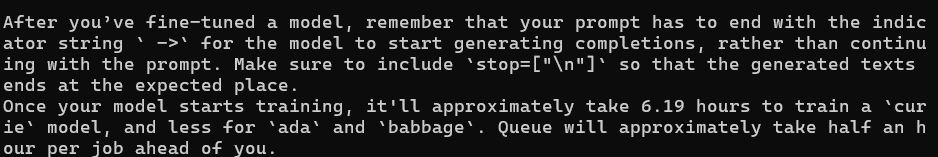